In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import sys

import random

import json

import numpy as np
import pandas as pd

from PIL import Image

from datetime import datetime

import torch
from torchvision.transforms.functional import to_pil_image
from transformers import CLIPImageProcessor, AutoModel

from tqdm.auto import tqdm

In [2]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

In [3]:
from stable_diffusion import StableDiffusion, CLIPTextEmbedder
from stable_diffusion.utils_image import get_image_data
from worker.image_generation.scripts.stable_diffusion_base_script import StableDiffusionBaseScript

INFO: Created a temporary directory at /tmp/tmp5e71hish
INFO: Writing /tmp/tmp5e71hish/_remote_module_non_scriptable.py


In [4]:
model_path = '../kcg-ml-image-pipeline/input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors'
tokenizer_path = '../kcg-ml-image-pipeline/input/model/clip/txt_emb_tokenizer'
transformer_path = '../kcg-ml-image-pipeline/input/model/clip/txt_emb_model'

prompt_path = './generated/prompt/empty.tsv'
OUTPUT_DIR = './generated/'

In [5]:
sampler = "ddim"
sampler_steps = 20
cfg_strength=12
image_width=512
image_height=512

In [6]:
os.makedirs(os.path.join(OUTPUT_DIR, 'image'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'meta'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'clip'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'embedding'), exist_ok=True)

# load model

In [7]:
txt2img = StableDiffusionBaseScript(
    sampler_name=sampler,
    n_steps=sampler_steps,
    force_cpu=False,
    cuda_device='cuda',
)

In [8]:
txt2img.initialize_latent_diffusion(
    autoencoder=None, 
    clip_text_embedder=None, 
    unet_model=None,
    path=model_path, 
    force_submodels_init=True
)

  encoder initialization...[DONE]	1,717.02ms                                      
  decoder initialization...[DONE]	433.35ms                                        
Autoencoder initialization...[DONE]	2,156.83ms                                    
U-Net initialization...[DONE]	5,799.45ms                                          
Latent Diffusion model initialization...[DONE]	7.90ms                             
stable diffusion checkpoint loading, from ../kcg-ml-image-pipeline/input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors...[DONE]	179.66ms
	missing keys 2: ['beta', 'alpha_bar']
	extra keys 14: ['alphas_cumprod', 'alphas_cumprod_prev', 'betas', 'log_one_minus_alphas_cumprod', 'model_ema.decay', 'model_ema.num_updates', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2', 'posterior_variance', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod']
model state loading...[DONE]	1,

In [9]:
clip_text_embedder = CLIPTextEmbedder(device='cuda')

In [10]:
clip_text_embedder.load_submodels(
    tokenizer_path=tokenizer_path,
    transformer_path=transformer_path
);

Loading tokenizer and transformer...[DONE]	909.74ms                               


In [11]:
def worker(positive_prompt, negative_prompt, seed=-1, cfg_strength=12, image_width=512, image_height=512):
    
    if seed == -1:
        seed = random.randint(0, 2 ** 24 - 1)

    with torch.no_grad():

        embedded_prompts, positive_pooler_output, _ = clip_text_embedder.forward_return_all(positive_prompt)
        negative_embedded_prompts, negative_pooler_output, _ = clip_text_embedder.forward_return_all(negative_prompt)
        
        positive_pooler_output = positive_pooler_output.detach().cpu().numpy()
        negative_pooler_output = negative_pooler_output.detach().cpu().numpy()

        latent = txt2img.generate_images_latent_from_embeddings(
            batch_size=1,
            embedded_prompt=embedded_prompts,
            null_prompt=negative_embedded_prompts,
            uncond_scale=cfg_strength,
            seed=seed,
            w=image_width,
            h=image_height
        )

        images = txt2img.get_image_from_latent(latent)

        output_file_hash, img_byte_arr = get_image_data(images)
    
    return output_file_hash, img_byte_arr, seed, positive_pooler_output, negative_pooler_output

# load dataset

In [12]:
prompts = pd.read_csv(prompt_path, sep='\t')

In [13]:
prompts = prompts.loc[~(prompts['positive_prompt'].str.contains('prompt') + prompts['negative_prompt'].str.contains('prompt') + prompts['positive_prompt'].str.contains('positive') + prompts['negative_prompt'].str.contains('positive'))]

In [9]:
prompts['positive_length'] = prompts['positive_prompt'].str.len()
prompts['negative_length'] = prompts['negative_prompt'].str.len()

In [33]:
num_positive_lengths = {i: j for i, j in zip(*np.unique(prompts['positive_length'], return_counts=True))}
num_negative_lengths = {i: j for i, j in zip(*np.unique(prompts['negative_length'], return_counts=True))}

In [79]:
num_sampling = 2000
max_length = 200

# weights = [(1 / (num_positive_lengths[positive_length] * num_negative_lengths[negative_length])) ** 0.5 for positive_length, negative_length in prompts[['positive_length', 'negative_length']].itertuples(index=False, name=None)]
weights = [min(1 / num_positive_lengths[positive_length], 1 / num_negative_lengths[negative_length]) for positive_length, negative_length in prompts[['positive_length', 'negative_length']].itertuples(index=False, name=None)]
weights = [i if i < 1 / num_sampling else 1 for i in weights]

In [84]:
indices = [i for i, (w, p) in enumerate(zip(weights, np.random.rand(len(weights)))) if w > p]
indices.extend(prompts.query(f'positive_length > {max_length} or negative_length > {max_length}').index)

In [85]:
min_length = 100
num_sampling = 200

for i in range(min_length, max_length + 1):
    
    ids = prompts.query(f'positive_length == {i}').index
    ids = list(ids)
    
    if len(ids) > num_sampling:
        ids = np.random.choice(ids, num_sampling, False)
        
    indices.extend(ids)
    
    ids = prompts.query(f'negative_length == {i}').index
    ids = list(ids)
    
    if len(ids) > num_sampling:
        ids = np.random.choice(ids, num_sampling, False)
        
    indices.extend(ids)
indices = list(set(indices))
len(indices)

33462

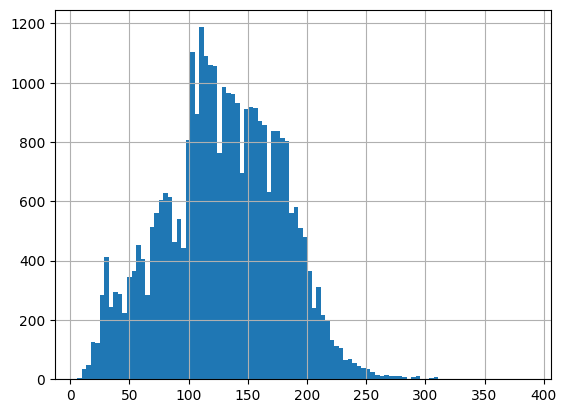

In [86]:
_ = prompts.loc[indices, 'positive_prompt'].str.len().hist(bins=100)

In [88]:
prompts = prompts.loc[indices]
prompts.loc[indices].to_csv(prompt_path, sep='\t', index=False)

# infer

In [16]:
for positive_prompt, negative_prompt in tqdm(prompts[['positive_prompt', 'negative_prompt']].itertuples(index=False), total=prompts.shape[0]):
    
    output_file_hash, img_byte_arr, seed, positive_pooler_output, negative_pooler_output = worker(positive_prompt, negative_prompt, seed=-1)
    
    creation_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    meta = dict(
        positive_prompt=positive_prompt, 
        negative_prompt=negative_prompt,
        file_hash=output_file_hash,
        sampler=sampler,
        sampler_steps=sampler_steps,
        cfg_strength=cfg_strength,
        image_width=image_width,
        image_height=image_height,
        creation_time=creation_time
    )
    
    with open(os.path.join(OUTPUT_DIR, 'image', f'{output_file_hash}.jpg'), 'wb') as f:
        f.write(img_byte_arr.getbuffer())
    
    with open(os.path.join(OUTPUT_DIR, 'meta', f'{output_file_hash}.json'), 'wt') as f:
        json.dump(meta, f)
        
    np.savez(
        os.path.join(OUTPUT_DIR, 'embedding', f'{output_file_hash}.npz'),
        positive_pooler_output=positive_pooler_output,
        negative_pooler_output=negative_pooler_output
    )

  0%|          | 0/33462 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# clip features

In [7]:
MODEL_NAME = 'openai/clip-vit-large-patch14'

BATCH_SIZE = 16

In [8]:
preprocessor = CLIPImageProcessor.from_pretrained(MODEL_NAME, local_files_only=True)

clip_model = AutoModel.from_pretrained(MODEL_NAME, local_files_only=True).cuda().eval()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [9]:
file_names = list()

for file_name in os.listdir(os.path.join(OUTPUT_DIR, 'image')):
    clip_path = os.path.join(OUTPUT_DIR, 'clip', file_name.replace('.jpg', '.npy'))
    
    if os.path.exists(clip_path):
        continue
        
    file_names.append(file_name)

In [10]:
for i in tqdm(range(0, len(file_names), BATCH_SIZE)):
    
    with torch.no_grad():

        images = list()
        for file_name in file_names[i:i+BATCH_SIZE]:
            image = Image.open(os.path.join(OUTPUT_DIR, 'image', file_name))
            image = preprocessor(images=image, return_tensors="pt")
            images.append(image['pixel_values'])

        images = torch.concat(images, dim=0)
    
        image_features = clip_model.get_image_features(pixel_values=images.to(clip_model.device))
        image_features = image_features.detach().cpu().numpy()
        
        for file_name, image_feature in zip(file_names[i:i+BATCH_SIZE], image_features):
            clip_path = os.path.join(OUTPUT_DIR, 'clip', file_name.replace('.jpg', '.npy'))
            np.save(clip_path, image_feature[None, ...])

  0%|          | 0/73 [00:00<?, ?it/s]